Importing all necessary modules

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, datasets, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split as tst

Reading the dataset

In [22]:
col_l = ['image', 'player']
df = pd.read_csv ('/content/drive/MyDrive/dataset_/players.csv', usecols=col_l)

im = 180 #Image Shape

images = []
players = []
frames = df.values.tolist()
for i in range(df.shape[0]):
    img = cv2.imread('/content/drive/MyDrive/dataset_/images/'+frames[i][1]+'/'+frames[i][0], 1)
    img = cv2.resize(img,(im,im))
    images.append(img)
    players.append(frames[i][1])

Defining Features and Labels:

In [23]:
play = set(players)
play = sorted(play)
play = list(play)

for i in range(len(players)):
    players[i] = play.index(players[i])

x = np.array(images)
y = np.array(players)

play

['bhuvneshwar_kumar',
 'dinesh_karthik',
 'hardik_pandya',
 'jasprit_bumrah',
 'k._l._rahul',
 'kedar_jadhav',
 'kuldeep_yadav',
 'mohammed_shami',
 'ms_dhoni',
 'ravindra_jadeja',
 'rohit_sharma',
 'shikhar_dhawan',
 'vijay_shankar',
 'virat_kohli',
 'yuzvendra_chahal']

Splitting the training and testing data AND Preprocessing It.

In [24]:
x_train, x_test, y_train, y_test = tst(x, y, test_size=0.15, random_state=10)
x_train, x_val, y_train ,  y_val = tst(x_train, y_train, test_size = 0.1, random_state = 10)

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_val=x_val.astype('float32')

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

num_classes = y_test.shape[1]

Defining our CNN model

In [25]:
def define_model():
    cnn = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape= x_train[0].shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=64, kernel_size=(2, 2), kernel_constraint=maxnorm(2), padding='same', activation='relu'),
        layers.Conv2D(filters=64, kernel_size=(2, 2), kernel_constraint=maxnorm(2), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=128, kernel_size=(2, 2),  kernel_constraint=maxnorm(2),  padding='same', activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(1000, activation='relu', kernel_constraint=maxnorm(4), 
                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                     bias_regularizer=keras.regularizers.l2(1e-4),
                     activity_regularizer=keras.regularizers.l2(1e-5)),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    cnn.compile(
        optimizer= 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return cnn

Data Augmentation 

In [26]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train)

Defining epochs and Batch Size

In [27]:
epochs = 50
batch_size = 32

Printing Model Summary

In [28]:
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 64)        8256      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 64)        16448     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 128)      

Training the Model

In [29]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/50
13/13 [==============================] - 52s 4s/step - loss: 19.4715 - accuracy: 0.0748 - val_loss: 5.5196 - val_accuracy: 0.0204
Epoch 2/50
13/13 [==============================] - 48s 4s/step - loss: 5.4290 - accuracy: 0.1015 - val_loss: 5.2766 - val_accuracy: 0.0408
Epoch 3/50
13/13 [==============================] - 47s 4s/step - loss: 5.2142 - accuracy: 0.0732 - val_loss: 5.0271 - val_accuracy: 0.0816
Epoch 4/50
13/13 [==============================] - 48s 4s/step - loss: 4.9681 - accuracy: 0.0874 - val_loss: 4.8026 - val_accuracy: 0.1224
Epoch 5/50
13/13 [==============================] - 50s 4s/step - loss: 4.7454 - accuracy: 0.0916 - val_loss: 4.5923 - val_accuracy: 0.1633
Epoch 6/50
13/13 [==============================] - 47s 4s/step - loss: 4.5342 - accuracy: 0.1666 - val_loss: 4.3751 - val_accuracy: 0.1633
Epoch 7/50
13/13 [==============================] - 47s 4s/step - loss: 4.3471 - accuracy: 0.1699 - val_loss: 4.1829 - val_accuracy: 0.1837
Epoch 8/50
13/13 [=

Evaluating It's Accuracy

In [30]:
_, acc = model.evaluate(x_test, y_test)
print('Accuracy :  %.3f' % (acc * 100.0))

3/3 [==============================] - 2s 729ms/step - loss: 4.4618 - accuracy: 0.4598
Accuracy :  45.977


Plotting Accuracy Graph

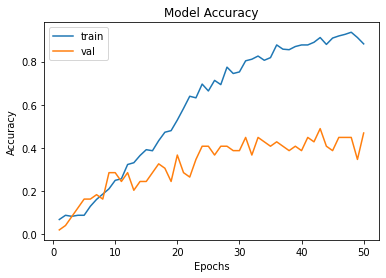

In [31]:
epoch_range=range(1, epochs+1)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

Plotting Loss Graph

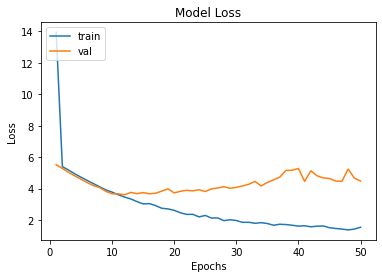

In [32]:
epoch_range=range(1, epochs+1)
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

Predicting All testing Data

In [33]:
y_preds=model.predict(x_test)
y_pred_labels = [np.argmax(i) for i in y_preds]
y_test_labels = [np.argmax(i) for i in y_test]

y_test_l = [play[i] for i in y_test_labels]
y_pred_l = [play[i] for i in y_pred_labels]


Printing and Comparing Some Testing Data with Predicted Values

In [34]:
print("-------------------------------------------------------Original Values-------------------------------------------------------------")
print()
print(y_test_l[:8])
print()
print("-------------------------------------------------------Predicted Values------------------------------------------------------------")
print()
print(y_pred_l[:8])

-------------------------------------------------------Original Values-------------------------------------------------------------

['ms_dhoni', 'rohit_sharma', 'dinesh_karthik', 'dinesh_karthik', 'dinesh_karthik', 'hardik_pandya', 'hardik_pandya', 'k._l._rahul']

-------------------------------------------------------Predicted Values------------------------------------------------------------

['ravindra_jadeja', 'hardik_pandya', 'dinesh_karthik', 'ravindra_jadeja', 'dinesh_karthik', 'hardik_pandya', 'hardik_pandya', 'k._l._rahul']


Displaying particular Image with Prediction

In [35]:
def plot_sample(a, b, index):
    plt.figure( figsize = (40, 3) )
    plt.imshow( a[index] )
    plt.title( play[np.argmax(b[index]) ] )
    y_p = model.predict(a)
    
    plt.xlabel("Predicted:  "+play[np.argmax(y_p[index])])

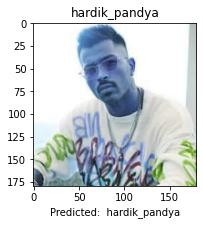

In [56]:
plot_sample(x_test, y_test, 9)

Defining Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
cm

array([[3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 1, 7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 2, 0, 2, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0],
       [0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 3, 7, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]])

Plotting Confsion Matrix

Text(69.0, 0.5, 'Truth')

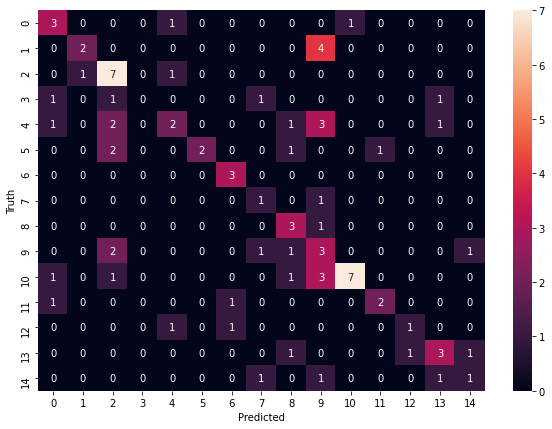

In [38]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')


Importing modules for WebCam

In [39]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

Defining Camera Capture

In [41]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Capturing the Image

In [54]:
image_file = take_photo()

<IPython.core.display.Javascript object>

Detecting and Predicting the Face

[[242  89 154 154]]
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 5.5759494e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
640 480


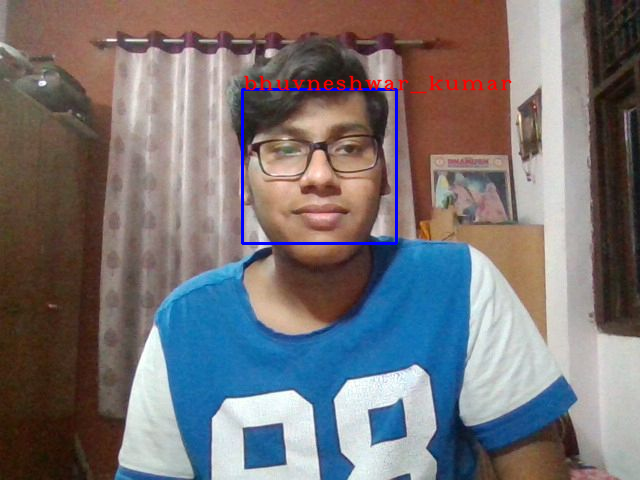

In [55]:
face_cascade = cv2.CascadeClassifier('/haarcascade_frontalface_default.xml')
image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
print(faces)

for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            a = x
            b = y

            face = image[x : x+w, y : y+h]
            if(face.size != 0):
                face = cv2.resize(face,(im,im))
                ar = face.reshape(1,im,  im,3)

                y_pred = model.predict(ar)
                print(y_pred)
                x = np.argmax(y_pred)
                txt = play[x]

                image = cv2.putText(image, txt , (a , b), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255),1 , cv2.LINE_AA)

(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)
